# Alzheimer predictions.

In [63]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf

## Importamos los datos y los mejoramos un poquito.

In [2]:
# Obtenemos los archivos y generamos los datos en un arreglo:

mild_d      = "Mild_Demented" #0
verymild_d  = "Very_Mild_Demented" #1
moderate_d  = "Moderate_Demented" #2
non_d       = "Non_Demented" #3

dicc = {0: "MiD", 1: "VMD", 2: "MoD", 3: "ND"}

Archivero = [mild_d, verymild_d, moderate_d, non_d]

x = np.zeros((6400, 128, 128, 1))
y = np.zeros((6400, 4))

In [3]:
cuenta = 0

for i in Archivero:
    ind_i = Archivero.index(i)
    for file in os.listdir(i):
        imagen_i = Image.open(i+"/"+file)
        arr_i = np.array(list(imagen_i.getdata())).reshape(128,128)
        x[cuenta, :, :, 0] = arr_i
        y[cuenta, ind_i] = 1
        cuenta+=1

Ahora vamos a imprimir una imagen

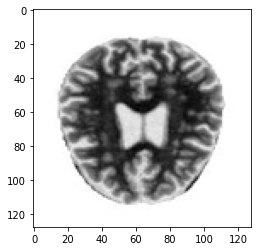

array([1., 0., 0., 0.])

In [4]:
n = 895

plt.imshow(x[n,:,:,0], cmap = "binary")
plt.show()
y[n]

Ahora vamos a normalizar:

In [5]:
maximos = [np.max(x[i,:,:,0]) for i in range(x.shape[0])]
x_norm = x/max(maximos)

Ahora veamos la misma imagen:

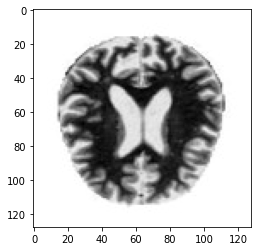

array([1., 0., 0., 0.])

In [6]:
n=100
plt.imshow(x_norm[n,:,:,0], cmap = "binary")
plt.show()
y[n]

In [7]:
x.shape

(6400, 128, 128, 1)

Y corroboremos que todo esta entre 0 y 1.

In [8]:
maximos = [np.max(x_norm[i,:,:,0]) for i in range(x.shape[0])]
norm = True
for i in maximos:
    if i<=1:
        norm *= True
    else:
        norm *= False
print("es: ",norm)

es:  1


El resultado es 1 por ende siempre es verdad que todos los máximos de cada imagen normalizada se encuentre entre 0 y 1.

## Partición de datos:

Ahora bien veamos la cantidad de datos que tenemos de cada clase:

In [9]:
c_1 = 0
c_2 = 0
c_3 = 0
c_4 = 0
    
for i in range(x.shape[0]):
    if y[i,0] == 1:
        c_1+=1
    if y[i,1] == 1:
        c_2+=1
    if y[i,2] == 1:
        c_3+=1
    if y[i,3] == 1:
        c_4+=1
print("La cantidad de MiD es: ", c_1, "\n \n",
      "La cantidad de MoD es: ", c_2, "\n \n",
      "La cantidad de ND es: ", c_3, "\n \n",
      "La cantidad de VMD es: ", c_4, "\n \n",)

La cantidad de MiD es:  896 
 
 La cantidad de MoD es:  2240 
 
 La cantidad de ND es:  64 
 
 La cantidad de VMD es:  3200 
 



Ahora vamos a elegir el 80% de cada total:

In [10]:
c1_x_aux = x_norm[:896,:,:,:]
c2_x_aux = x_norm[896:896+64,:,:,:]
c3_x_aux = x_norm[896+64:896+64+3200,:,:,:]
c4_x_aux = x_norm[896+64+3200:896+64+3200+2240,:,:,:]
c1_y_aux = y[:896,:]
c2_y_aux = y[896:896+64,:]
c3_y_aux = y[896+64:896+64+3200,:]
c4_y_aux = y[896+64+3200:896+64+3200+2240,:]

In [11]:
c1_x_aux.shape

(896, 128, 128, 1)

Ahora importemos sklearn para poder hacer la particion en corto.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x1_train, x1_test, y1_train, y1_test = train_test_split(c1_x_aux, c1_y_aux, test_size=0.2)
x2_train, x2_test, y2_train, y2_test = train_test_split(c2_x_aux, c2_y_aux, test_size=0.2)
x3_train, x3_test, y3_train, y3_test = train_test_split(c3_x_aux, c3_y_aux, test_size=0.2)
x4_train, x4_test, y4_train, y4_test = train_test_split(c4_x_aux, c4_y_aux, test_size=0.2)

Ahora concatenamos las x's de entrenamiento y de testeo y los targets.

In [14]:
x_tr = np.concatenate((x1_train,x2_train,x3_train,x4_train), axis = 0)
x_te = np.concatenate((x1_test,x2_test,x3_test,x4_test), axis = 0)
y_tr = np.concatenate((y1_train,y2_train,y3_train,y4_train), axis = 0)
y_te = np.concatenate((y1_test,y2_test,y3_test,y4_test), axis = 0)

In [15]:
print(x_tr.shape, x_te.shape)

(5119, 128, 128, 1) (1281, 128, 128, 1)


Ahora solo basta codificar la CNN que ideé:

## Implementación de CNN.

In [85]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow import keras

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import CategoricalHinge

from tensorflow.keras import Sequential

from tensorflow.keras.utils import plot_model

import pydot

In [86]:
def modelo_001(in_shape,nf1,nf2,activation):
    modelo = Sequential()
    #capa 1
    modelo.add(Conv2D(nf1,7,padding = "same",input_shape = in_shape))
    modelo.add(Activation(activation))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling2D(pool_size=(2,2)))
    #capa 2
    modelo.add(Conv2D(nf2,5,padding = "same",input_shape = in_shape))
    modelo.add(Activation(activation))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling2D(pool_size=(2,2)))
    #capa 3
    modelo.add(Conv2D(nf2,3,padding = "same",input_shape = in_shape))
    modelo.add(Activation(activation))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling2D(pool_size=(2,2)))
    #capa 4
    modelo.add(Conv2D(nf2,3,padding = "same",input_shape = in_shape))
    modelo.add(Activation(activation))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling2D(pool_size=(2,2)))
    #capa 5
    modelo.add(Flatten())
    modelo.add(Dropout(0.25))
    modelo.add(Dense(50, kernel_initializer="he_uniform"))
    modelo.add(Activation(activation))
    modelo.add(Dense(30, kernel_initializer="he_uniform"))
    modelo.add(Activation(activation))
    modelo.add(Dense(20, kernel_initializer="he_uniform"))
    modelo.add(Activation(activation))
    modelo.add(Dense(4, kernel_initializer="he_uniform"))
    modelo.add(Activation("softmax"))
    return(modelo)

In [87]:
modelo1 = modelo_001(x_tr[0,:,:,:].shape,28,31,"sigmoid")

In [88]:
plot_model(modelo1, to_file = "modelo1.png", show_shapes=True, rankdir='TB', show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [89]:
modelo1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 28)      1400      
_________________________________________________________________
activation_41 (Activation)   (None, 128, 128, 28)      0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 128, 28)      112       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 28)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 31)        21731     
_________________________________________________________________
activation_42 (Activation)   (None, 64, 64, 31)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 31)       

In [90]:
# Optimizadores, callback y funciones de pérdida

lr = 0.01
opt1 = keras.optimizers.SGD(learning_rate = lr, nesterov = False)
perdida = "categorical_crossentropy"
metr_fun = "accuracy"
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [91]:
modelo1.compile(optimizer=opt1, loss=perdida, metrics=[metr_fun])

In [102]:
historia = modelo1.fit(x = x_tr, y = y_tr, epochs = 130, callbacks=[callback])

Epoch 1/130
160/160 [==============================] - 2s 13ms/step - loss: 0.0644 - accuracy: 0.9883
Epoch 2/130
160/160 [==============================] - 2s 13ms/step - loss: 0.0658 - accuracy: 0.9879
Epoch 3/130
160/160 [==============================] - 2s 13ms/step - loss: 0.0633 - accuracy: 0.9885
Epoch 4/130
160/160 [==============================] - 2s 13ms/step - loss: 0.0632 - accuracy: 0.9869
Epoch 5/130
160/160 [==============================] - 2s 13ms/step - loss: 0.0650 - accuracy: 0.9867
Epoch 6/130
160/160 [==============================] - 2s 13ms/step - loss: 0.0648 - accuracy: 0.9863


In [114]:
loss,acc = modelo1.test_on_batch(x_te,y_te)
print("En el conjunto de testeo la pérdida es de:", loss, "\n \n",
      "y en el mismo conjunto de testeo la precision es de:", acc)

En el conjunto de testeo la pérdida es de: 0.18881231546401978 
 
 y en el mismo conjunto de testeo la precision es de: 0.9484777450561523


In [116]:
a,b,c = historia.epoch,historia.history["loss"],historia.history["accuracy"]

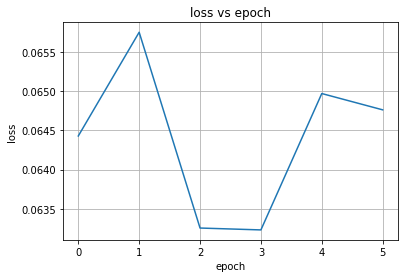

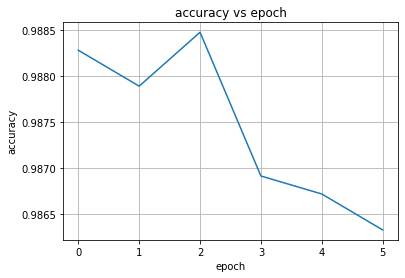

In [121]:
plt.plot(a,b)
plt.title("loss vs epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()
plt.plot(a,c)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.title("accuracy vs epoch")
plt.show()

In [122]:
modelo1.save("modelo001_demencia")

INFO:tensorflow:Assets written to: modelo001_demencia\assets
